## Import

In [0]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable
import torchvision.models as models
from copy import *
import torch.nn.functional as F
import torch.nn as nn
from scipy import optimize
import math

%matplotlib inline



In [0]:
from torchvision import datasets, transforms


batch_size=30
n=batch_size

train_loader = torch.utils.data.DataLoader(datasets.MNIST('mnist_data', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=n, 
shuffle=True)


test_loader = torch.utils.data.DataLoader(datasets.MNIST('mnist_data', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=n, 
shuffle=True)

d,t=28*28,10

0it [00:00, ?it/s]

9920512it [00:01, 9560850.40it/s]                            


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 140876.77it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2237682.61it/s]                            
0it [00:00, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 53045.57it/s]            


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:

for batch_idx, (inputs, targets) in enumerate(train_loader):
    if batch_idx >=1:
        break
    print(targets.size())

torch.Size([30])


##  Utilitaire

In [0]:
global to
to=(np.sqrt(5)-1)/2

def transforme(target):
    #print(target.item())
    res=torch.zeros(1,10)
    res[0,int(target.item())]=1
    return res
def transforme2(target):
    #print(target.item())
    res=torch.zeros(1,30)
    res[0,int(target.item())]=1
    return res



def accuracy(model,break_time):
    nb,acc=0,0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if batch_idx >=break_time:
            break
        #a = time.time()
        for k in range(n) :
            
            x = inputs[k][0].resize(784).type(torch.FloatTensor)
            y = transforme(targets[k]).type(torch.FloatTensor)
            ypred=model.forward(x)
            if ypred.argmax()==y.argmax():
                acc+=1
            nb+=1
    return acc/nb
  
def accuracy_train(model,break_time):
    nb,acc=0,0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if batch_idx >=break_time:
            break
        #a = time.time()
        for k in range(n) :
            
            x = inputs[k][0].resize(784).type(torch.FloatTensor)
            y = transforme(targets[k]).type(torch.FloatTensor)
            ypred=model.forward(x)
            if ypred.argmax()==y.argmax():
                acc+=1
            nb+=1
    return acc/nb

def moyenne(LG, G_i):
    
    n = len(LG)
    
    li_key=LG[0].state_dict().keys()
    
    for key in li_key:

        couche_G = G_i.state_dict()[key]

        G = 1*LG[0].state_dict()[key]

        for k in range(1,n):
            Gk = LG[k].state_dict()[key]
            G.add_(Gk)

        couche_G.data.zero_()
        couche_G.data.add_(G/n)

def copy_c(model):
    res=Mnist_CNN()
    for (couche_c,couche) in zip(res.parameters(),model.parameters()):
        couche_c.data.zero_()
        couche_c.data.add_(couche.data)
        
    return res
  
  
def calcule_loss_test(criterion, model, nb):
    res = 0
    nn = 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if batch_idx > nb :
            break
        trainloader=[]
        for k in range(n) :

            x = inputs[k].resize(784).type(torch.FloatTensor)
            y=transforme(torch.tensor([targets[k]]).type(torch.FloatTensor))
            
            ypred = model(x)
            
            res += criterion(ypred,y)
            nn+=1

    return res/nn

# Applique l'optimiseur

In [0]:
def applique_opt(opti,break_time,model,lam=0.9):
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if batch_idx >=break_time:
            break
        trainloader = []
        old_model=copy_c(opti.model)
        #a = time.time()
        for k in range(n) :
            
            x = inputs[k].resize(784).type(torch.FloatTensor)
            y = torch.tensor([targets[k]]).type(torch.FloatTensor)
            
            trainloader.append((x,y))
            
        opti.trainloader=trainloader
        
        #opti.t0 += time.time() - a
        
        opti.descente()
        if batch_idx>1:
          lamm=1
        else:
          lamm=lam
        new_model=copy_c(opti.model)
        for (couche,couche_old) in zip(opti.model.parameters(),old_model.parameters()):
            couche.data.sub_(couche_old.data)
            couche.data.mul_(lamm)
            couche.data.add_(couche_old.data)
            #couche.data=couche_old.data+lam*(couche.data-couche_old.data)
        
def applique_opt_acc(opti,break_time,model,lam=0.9):
    acc=[]
    loss_=[]
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if batch_idx >=break_time:
            break
        trainloader = []
        old_model=copy_c(opti.model)
        #a = time.time()
        for k in range(n) :
            
            x = inputs[k].resize(784).type(torch.FloatTensor)
            y=torch.tensor([targets[k]]).type(torch.FloatTensor)
            
            trainloader.append((x,y))
            
        opti.trainloader=trainloader
        
        #opti.t0 += time.time() - a
        
        opti.descente()
        
        new_model=copy_c(opti.model)
        for (couche,couche_old) in zip(opti.model.parameters(),old_model.parameters()):
            couche.data.sub_(couche_old.data)
            couche.data.mul_(lam)
            couche.data.add_(couche_old.data)
        
        
        res=accuracy(opti.model,33)
        loss=calcule_loss_test(criterion,opti.model,20).item()
        acc.append(res)
        loss_.append(loss)
        print('batch {} acc {}'.format(batch_idx,res))
    return acc,loss_
def applique_opt_acc_train(opti,break_time,model,criterion):
    acc=[]
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if batch_idx >=break_time:
            break
        trainloader = []
        #a = time.time()
        for k in range(n) :
            
            x = inputs[k].resize(784).type(torch.FloatTensor)
            y=torch.tensor([targets[k]]).type(torch.FloatTensor)
            
            trainloader.append((x,y))
            
        opti.trainloader=trainloader
        
        #opti.t0 += time.time() - a
        
        opti.descente()
        res=accuracy_train(opti.model,100)
        acc.append(res)
        print('batch {} acc {}'.format(batch_idx,res))
    return acc

        
        
def plusieurs_batch(nb_batch,opti):
    for i in range(nb_batch):
        opti.descente()
        print("{} ème batch fini".format(i))
        #print("accuracy : {} ".format(accuracy(model,100)))
    return 
        
def gene_train(n):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if batch_idx >0 :
            break
        trainloader=[]
        for k in range(n) :

            x = inputs[k].resize(784).type(torch.FloatTensor)
            y=torch.tensor([targets[k]]).type(torch.FloatTensor)

            trainloader.append((x,y))

    return trainloader
  
def gene_train2(n):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if batch_idx >0 :
            break
        trainloader=[]
        for k in range(n) :

            x = inputs[k].resize(3072).type(torch.FloatTensor)
            y=torch.tensor([targets[k]]).type(torch.FloatTensor)

            trainloader.append((x,y))

    return trainloader

# Classes d'optimiseurs

### General

In [0]:
class Optimimi() :
    def __init__ (self,trainloader,n,lr,T,model,f_momen,momentum=0,ada=False,adam=False,nag=False):
        
        self.n = n
        self.trainloader = trainloader #liste de (x,y)
        self.loss = None #criterion(model(trainloader[0][0]),trainloader[0][1])
        
        self.call_psi = True
        
        self.T = T
        self.t = 0
        #self.lr = lr
        self.proba=0.3
        
        self.Loss = []
        self.TPS = []
        self.t0 = time.time()
        self.TPSv = []

        self.MG = Mnist_CNN()
        self.LG = None
        
        self.momentum=f_momen(momentum)
        self.ada = ada
        self.G_i = Mnist_CNN()
        
        
        self.ts = None #svrg
        self.s = None #svrg
        self.m = 50 #svrg 
        
        self.model=model
        self.mod_old=copy_c(model)
        
        if model is None:
            print('Modèle pas entré')
        self.lr=lr
        
        if ada :
            self.adaG = Mnist_CNN() #on initialise couche_ada petit pour ne jamais divisier par 0
            for couche_ada in self.adaG.parameters():
                couche_ada.data.zero_()
                couche_ada.data.add_(1e-15)
                #print(couche_ada)
            self.lr=Mnist_CNN()
            self.alpha=0.00001
        self.adam=adam
        self.nag=nag
        
        
        if adam:
            
            self.vk=[]
            self.mk=Mnist_CNN()
            for couche_M in self.mk.parameters():
                couche_M.data.zero_()
                self.vk.append(0)
            self.beta1=0.9
            self.beta2=0.999
            self.alpha=0.001
            
        self.muappr=Mnist_CNN()
        for couche in self.muappr.parameters():
            couche.data.zero_()
          
        
    def Psi(self, autre=None) :
        running_loss = 0
        self.loss = []
        
        for k in range(self.n) :
            inputs,labels = self.trainloader[k]
            if autre is None:
                outputs = self.model(inputs).type(torch.FloatTensor)
            else:
                outputs=autre(inputs).type(torch.FloatTensor)
            labels=transforme(labels).type(torch.FloatTensor)
            
            loss = criterion(outputs, labels)
            
            self.loss.append(loss)

            running_loss += loss.data.item()
        
        self.call_psi = False
        return running_loss/self.n
    
    def actualise_gradient (self, k,autre=None) :
        '''
        Étant donné une fonction Psi_i,
        correspondant au Psi_i de nos nos notations

        renvoie le gradient de Psi_i calculé en point

        input :
        Psi_i : fonction (en pratique self.losses[i]
        point : vecteur (de dimension d)
        dt : pas permettant de calculer le gradient

        output :
        grad : vecteur (de dimension d)
        '''

        # pas propre à chaque optimizer
        
        #On suppose que Psi a déjà été appelé (juste avant)
        
        
        self.Psi(autre)

        loss = self.loss[k]
        
        loss.backward()
        
        
        return

    def next_step (self) :
        '''
        input :
        w_i : point (vecteur de dimension d) à l'instant i
        lr : learning rate

        output :

        w_i+1 : point à l'instant i+1 (vecteur de dimension d) après avoir effectué une itération
        '''
        pass


    def descente (self) :
        '''
        input :
        lr : learning rate

        output : point final après convergence / T itérations 
        '''
        convergence=False
        self.t0 = time.time()
        self.t=0
        while not convergence and self.t<self.T:
            #print("temps passé : {}".format(t))
            a = time.time()
            self.t+=1
            self.TPS.append(self.t)
            self.TPSv.append(time.time()-self.t0)
            loss=0
            self.Loss.append(self.Psi(None))
            self.t0 += time.time() - a
            
            mod=self.model
            
            if self.ada : #divise lr par la somme des carrés des gradients passés
                for (couche,couche_G,couche_lr) in zip(self.adaG.parameters(),self.G_i.parameters(),self.lr.parameters()):
                    tmp=couche_G.data.mul_(couche_G.data)
                    couche.data.add_(tmp)
                    coeff=torch.sqrt(couche.data)
                    tmp=1/coeff*self.alpha
                    couche_lr.data.zero_()
                    couche_lr.data.add_(tmp)
            
            if self.nag :
                
                self.mod_old=copy_c(self.model)
                self.next_step()
                mod_act=copy_c(self.model)
                if self.t>0 :
                    for (couche,couche_act,couche_old) in zip(self.model.parameters(),mod_act.parameters(),self.mod_old.parameters()):
                        #couche.data.mul_(1-self.momentum(self.t))
                        couche.data.add_(self.momentum(self.t)*(couche_act-couche_old))
            
            else :
                mod_oold=copy_c(self.mod_old)
                self.mod_old=copy_c(self.model)

                self.next_step()

                if self.momentum(self.t) != 0 and self.t>0:
                    for (couche,couche_old,couche_oold) in zip(self.model.parameters(),self.mod_old.parameters(),mod_oold.parameters()):
                        #couche.data.mul_(1-self.momentum(self.t))
                        couche.data.add_(self.momentum(self.t)*(couche_old-couche_oold))

            
            if self.t > 10 and abs(self.Loss[-2]-self.Loss[-1]) < 0.0000000000001 :
                convergence=False
                
            
                    
    def cherche_lr(self,eps=0.0000000001): 
        '''Applique la méthode de la section dorée pour minimiser f(w-alphaG)
        et déduire alpha'''
        
        global to
        
        def f(alpha): #fonction f à minimiser
            
            mod=Mnist_CNN()
            for (couche_cour,couche,couche_G) in zip(mod.parameters(),self.model.parameters(),self.G_i.parameters()):
                couche_cour.data.zero_()
                couche_cour.data.add_(couche.data)
                couche_cour.data.sub_(alpha*couche_G.data)
            
            return self.Psi(mod)
        #application de la section dorée
        a,b=0,1
        x1,x2=a+(1-to)*(b-a),a+to*(b-a)
        f1,f2=f(x1),f(x2)
        while (b-a)>eps:
            if f1>f2 :
                a,x1,fi=x1,x2,f2
                x2=a+to*(b-a)
                f2=f(x2)
            else:
                b,x2,f2=x2,x1,f1
                x1=a+(1-to)*(b-a)
                f1=f(x1)
        print("Learning rate calculé : {}".format((x1+x2)/2))
        return (x1+x2)/2


### FG

In [0]:
class GradientDescentMi(Optimimi) :
    def next_step(self):
    
        if self.ada:
            if self.alpha is None:
                self.alpha=self.cherche_lr()
            for (couche,couche_G,couche_lr) in zip(self.model.parameters(),self.G_i.parameters(),self.lr.parameters()):
                self.model.zero_grad()
                self.actualise_gradient(0)
                G=couche.grad.data
                for k in range(1,self.n):
                    self.model.zero_grad()
                    self.actualise_gradient(k)
                    G.add_(couche.grad.data)
                couche.data.sub_(couche_lr*G/self.n)
                
                couche_G.data.zero_()
                couche_G.data.add_(G)
                
        else:
            for (couche,couche_G) in zip(self.model.parameters(),self.G_i.parameters()):
                self.model.zero_grad()
                self.actualise_gradient(0)
                G=1*couche.grad.data
                for k in range(1,self.n):
                    self.model.zero_grad()
                    self.actualise_gradient(k)
                    G.add_(couche.grad.data)
                
                couche_G.data.zero_()
                couche_G.data.add_(G)
                
            if self.lr is None and self.t<1:
                self.lr=self.cherche_lr()
                
            for (couche,couche_G) in zip(self.model.parameters(),self.G_i.parameters()):
                couche.data.sub_(self.lr*couche_G.data/self.n)
        self.call_Psi = True
            

### SAG

In [0]:

class SAGmi(Optimimi) :
    def next_step(self):
            
        ##
        
        if self.LG is None :
            self.LG=[]
            for k in range(self.n):
                mod=Mnist_CNN()
                self.model.zero_grad()
                self.actualise_gradient(k)
                for (couche,couche_mod) in zip(self.model.parameters(),mod.parameters()):
                    
                    G=1*couche.grad.data
                    
                    couche_mod.data.zero_()
                    couche_mod.data.add_(G)
                    
                self.LG.append(mod)
                
            moyenne(self.LG,self.MG)
                
        
        k = random.randrange(self.n)

        self.model.zero_grad()
        self.actualise_gradient(k)
        for (couche,couche_LG,couche_MG) in zip(self.model.parameters(),self.LG[k].parameters(),self.MG.parameters()):
            
            couche_MG.data.add_((couche.grad.data - couche_LG.data)/self.n)
            couche_LG.data.zero_()
            couche_LG.data.add_(couche.grad.data)
            
            
        for (couche,couche_MG) in zip(self.model.parameters(),self.MG.parameters()):
            couche.data.sub_(self.lr*couche_MG.data)
        
        #self.call_Psi = True

### SGD

In [0]:
class SGDMi(Optimimi) :
    def next_step(self):
        k=random.randrange(self.n)

        self.model.zero_grad()
        self.actualise_gradient(k)

        for couche in self.model.parameters():
            G=1*couche.grad.data
            tmp=G
            couche.data.sub_(tmp*self.lr)
        self.call_Psi = True


### NEW SAGA

In [0]:
class new_SAGAmi(Optimimi) :
  
    def ft_tracking(self) :
        #for _ in range(self.card_I) :
        if True:
            k2 = np.argmin(np.array(self.LastUpdate))

            self.model.zero_grad()
            self.actualise_gradient(k2)
            for (couche,couche_LG,couche_MG) in zip(self.model.parameters(),self.LG[k2].parameters(),self.MG.parameters()):

                couche_MG.data.add_((couche.grad.data - couche_LG.data)/self.n) #on actualise MG
                couche_LG.data.zero_()
                couche_LG.data.add_(couche.grad.data)

            self.LastUpdate[k2] = self.t

    def next_step(self) :
        if self.LG is None :
            self.LG=[]
            for k in range(self.n):
                mod=Mnist_CNN()
                self.model.zero_grad()
                self.actualise_gradient(k)
                for (couche,couche_mod) in zip(self.model.parameters(),mod.parameters()):
                    
                    G=1*couche.grad.data
                    
                    couche_mod.data.zero_()
                    couche_mod.data.add_(G)
                    
                self.LG.append(mod)
                
            moyenne(self.LG,self.MG)
            self.G_i=copy_c(self.MG)
            
            self.LastUpdate = [self.t for i in range(self.n)]
                    
        p=random.random()
        
        
        if self.Tracking :
            self.ft_tracking()
        
        
        Lk = random.sample([i for i in range(n)], self.card_I)

        
        mod_int=Mnist_CNN()
        
        for k in Lk[:-1]:

            self.model.zero_grad()
            self.actualise_gradient(k)

            for (couche,couche_LG,couche_MG) in zip(self.model.parameters(),self.LG[k].parameters(),self.MG.parameters()):

                couche_MG.data.add_((couche.grad.data - couche_LG.data)/self.n) #on actualise MG
                couche_LG.data.zero_()
                couche_LG.data.add_(couche.grad.data) #on actualise LG
            self.LastUpdate[k] = self.t
        
        k = Lk[-1]
        
        self.model.zero_grad()
        self.actualise_gradient(k)

        for (couche,couche_int,couche_LG,couche_MG) in zip(self.model.parameters(),mod_int.parameters(),self.LG[k].parameters(),self.MG.parameters()):

            couche_int.data=couche_MG.data + couche.grad.data - couche_LG.data
            couche_MG.data.add_((couche.grad.data - couche_LG.data)/self.n) #on actualise MG
            couche_LG.data.zero_()
            couche_LG.data.add_(couche.grad.data) #on actualise LG
        
        self.LastUpdate[k] = self.t

        
        self.G_i=copy_c(mod_int)
        
        if self.adam:
            if self.ada :
              for (couche,couche_mk,couche_int,couche_vk,couche_lr) in zip(self.model.parameters(),self.mk.parameters(),mod_int.parameters(),self.vk,self.lr.parameters()):

                couche_mk.data=(couche_mk.data*self.beta1+(1-self.beta1)*couche_int.data)

                couche_vk=(self.beta2*couche_vk+(1-self.beta2)*((couche_int.data*couche_int.data).sum())).item()


                mk=couche_mk.data/(1-self.beta1**self.t)
                vk=math.sqrt(couche_vk/(1-self.beta2**self.t))

                couche.data.sub_(couche_lr/(vk+1e-8)*mk)

            else :
              
              for (couche,couche_mk,couche_int,couche_vk) in zip(self.model.parameters(),self.mk.parameters(),mod_int.parameters(),self.vk):

                couche_mk.data=(couche_mk.data*self.beta1+(1-self.beta1)*couche_int.data)

                couche_vk=(self.beta2*couche_vk+(1-self.beta2)*((couche_int.data*couche_int.data).sum())).item()


                mk=couche_mk.data/(1-self.beta1**self.t)
                vk=math.sqrt(couche_vk/(1-self.beta2**self.t))

                couche.data.sub_(self.alpha/(vk+1e-8)*mk)
        
        else :
          if self.ada :
            for (couche,couche_int,couche_lr) in zip(self.model.parameters(),mod_int.parameters(),self.lr.parameters()):
                couche.data.sub_(couche_lr*couche_int.data)
          else:
            for (couche,couche_int) in zip(self.model.parameters(),mod_int.parameters()):
                couche.data.sub_(self.lr*couche_int.data)

        self.call_Psi = True        

### SAGA

In [0]:
class SAGAmi(Optimimi) :
    def next_step(self) :
        if self.LG is None :
            self.LG=[]
            for k in range(self.n):
                mod=Mnist_CNN()
                self.model.zero_grad()
                self.actualise_gradient(k)
                for (couche,couche_mod) in zip(self.model.parameters(),mod.parameters()):
                    
                    G=1*couche.grad.data
                    
                    couche_mod.data.zero_()
                    couche_mod.data.add_(G)
                    
                self.LG.append(mod)
            moyenne(self.LG,self.MG)
                
        
        k = random.randrange(self.n)
            
        mod_int=Mnist_CNN()
        
        
        self.model.zero_grad()
        self.actualise_gradient(k)
        
        for (couche_int,couche_MG,couche_G,couche_LG) in zip(mod_int.parameters(),self.MG.parameters(),self.model.parameters(),self.LG[k].parameters()):
            
            G=1*couche_G.grad.data
            
            couche_int.data.zero_()
            couche_int.data.add_(couche_MG.data + G - couche_LG.data)
            
            couche_MG.data = couche_MG.data + (G - couche_LG.data)/self.n
            couche_LG.data = 1*couche_G.grad.data
        
        for (couche,couche_int) in zip(self.model.parameters(),mod_int.parameters()):
            couche.data.sub_(self.lr*couche_int.data)
        
        #self.call_Psi = True
        

### SVRG

In [0]:
class SVRGmi(Optimimi) :
    
    def calcule_mu_appr(self, dest) :
        LG=[]
        for k in range(self.n) :
            
            mod=Mnist_CNN()
            model.zero_grad()
            self.actualise_gradient(k,model)
            for (couche,couche_tmp) in zip(model.parameters(),mod.parameters()):
                couche_tmp.data=1*couche.grad.data   
            LG.append(mod)
        moyenne(LG,dest)
    
    def next_step(self) :
        
        if self.s is None :
            self.s = 0
            self.ts = 0
        
        if self.ts == self.m :
            self.ts = 0
            self.s +=1
        
        if self.ts == 0 :
            self.modappr=copy_c(self.model)
            self.calcule_mu_appr(self.muappr)
        
        its = random.randrange(self.n)
        
        self.model.zero_grad()
        self.actualise_gradient(its)
        
        self.ts += 1
        
        if self.s == 0 :
          for couche in self.model.parameters():

              G=couche.grad.data
              couche.data.sub_(self.lr*G)
          return

     
        
        tmp=Mnist_CNN()
        
        
        for (couche_tmp,couche,couche_muappr) in zip(tmp.parameters(),self.model.parameters(),self.muappr.parameters()):
            
            G=couche.grad.data
            couche_tmp.data = G+couche_muappr.data
            
        
        #model_tmp2 = copy_c(model)
        
        #for couche,couche_approx in zip(self.model.parameters(),self.modappr.parameters()) :
        #    couche.data = couche_approx.data
        
        self.modappr.zero_grad()
        self.actualise_gradient(its,self.modappr)
        
        for (couche_tmp, couche, couche_modappr) in zip(tmp.parameters(), self.model.parameters(),self.modappr.parameters()):
            
            G_appr=couche_modappr.grad.data
            
            couche_tmp.data = couche_tmp.data - G_appr
            couche.data.sub_(self.lr*couche_tmp.data)
        
        self.call_Psi = True

### SVRG mixé avec SAGA

# Modèles

In [0]:
class My_Model_1(nn.Module):
    def __init__(self,D_in,D_out):
        super(My_Model_1, self).__init__()
        self.layer = nn.Linear(D_in,D_out)
    def forward(self,x):
        out = self.layer(x)
        return out

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = n, 784, 100, 10


model = My_Model_1(D_in, D_out)

In [0]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super(Mnist_CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64,10)
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        
        
        xb = F.max_pool2d(xb, 2)
        xb=xb.reshape(xb.size(0),-1)
        
        xb=self.fc1(xb)
        return xb.view(-1, xb.size(1))

In [0]:
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super(Mnist_CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(192,30)
    def forward(self, xb):
        xb = xb.view(-1, 1, 48, 64)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        
        
        xb = F.max_pool2d(xb, 2)
        xb=xb.reshape(xb.size(0),-1)
        xb=self.fc1(xb)
        return xb.view(-1, xb.size(1))

In [0]:
trainloader=gene_train2(n)

x=trainloader[0][0]
y=trainloader[0][1]
model=Mnist_CNN()
print(model(x).size())
print(y.size())
            

torch.Size([1, 30])
torch.Size([1])


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [0]:
class Mnist_CNN_nul(nn.Module):
    def __init__(self):
        super(Mnist_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        x=x.view(-1,1,28,28)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out.view(-1,out.size(1))

In [0]:

x=trainloader[0][0]
model=Mnist_CNN()
print(model(x).size())
print(7*7*64)            

torch.Size([1, 10])
3136


In [0]:
def momen(momentum):
    def f(t):
        return momentum
    return f

In [0]:
model_c=Mnist_CNN()

# Compare SAGA

### comparaisons

Nouvelle version vanilla- Loss 0.01284001221259435


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Nouvelle version momentum 0.99, adam, nag- Loss 0.009437575936317444
Nouvelle version momentum 0.99, nag- Loss 0.025805910831938186
Nouvelle version momentum adam - Loss 0.011713242623955011
saga - Loss 0.006684760058609148


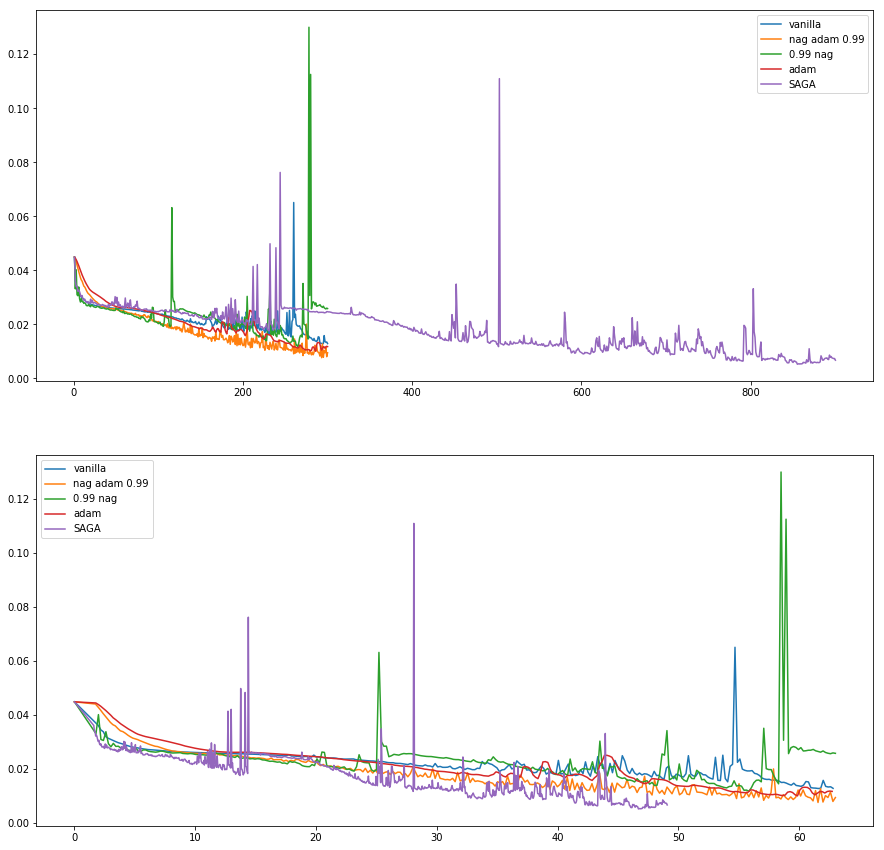

In [0]:
plt.figure(2,(15,15))


T=300
card=3

criterion=nn.MSELoss()
model=copy_c(model_c)

optMiSAGAmi=new_SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0)
optMiSAGAmi.proba=0
optMiSAGAmi.card_I = card
optMiSAGAmi.Tracking = True
optMiSAGAmi.descente()
plt.subplot(211)
plt.plot(optMiSAGAmi.TPS, optMiSAGAmi.Loss,label='vanilla')
plt.subplot(212)
plt.plot(optMiSAGAmi.TPSv, optMiSAGAmi.Loss,label='vanilla')

print("Nouvelle version vanilla- Loss {}".format(optMiSAGAmi.Loss[-1]))

criterion=nn.MSELoss()
model=copy_c(model_c)

optMiSAGAmi=new_SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0.99,nag=True,adam=True)
optMiSAGAmi.proba=0
optMiSAGAmi.card_I = card
optMiSAGAmi.Tracking = True
optMiSAGAmi.beta1=0

optMiSAGAmi.descente()
plt.subplot(211)
plt.plot(optMiSAGAmi.TPS, optMiSAGAmi.Loss,label='nag adam 0.99')
plt.subplot(212)
plt.plot(optMiSAGAmi.TPSv, optMiSAGAmi.Loss,label='nag adam 0.99')

print("Nouvelle version momentum 0.99, adam, nag- Loss {}".format(optMiSAGAmi.Loss[-1]))


criterion=nn.MSELoss()
model=copy_c(model_c)

optMiSAGAmi=new_SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0.99,nag=True)
optMiSAGAmi.proba=0.
optMiSAGAmi.card_I = card
optMiSAGAmi.Tracking = True

optMiSAGAmi.descente()
plt.subplot(211)
plt.plot(optMiSAGAmi.TPS, optMiSAGAmi.Loss,label='0.99 nag')
plt.subplot(212)
plt.plot(optMiSAGAmi.TPSv, optMiSAGAmi.Loss,label='0.99 nag')

print("Nouvelle version momentum 0.99, nag- Loss {}".format(optMiSAGAmi.Loss[-1]))

criterion=nn.MSELoss()
model=copy_c(model_c)


criterion=nn.MSELoss()
model=copy_c(model_c)

optMiSAGAmi=new_SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0,adam=True)
optMiSAGAmi.proba=0
optMiSAGAmi.card_I = card
optMiSAGAmi.Tracking = True

optMiSAGAmi.descente()
plt.subplot(211)
plt.plot(optMiSAGAmi.TPS, optMiSAGAmi.Loss,label='adam')
plt.subplot(212)
plt.plot(optMiSAGAmi.TPSv, optMiSAGAmi.Loss,label='adam')

print("Nouvelle version momentum adam - Loss {}".format(optMiSAGAmi.Loss[-1]))

T=3*T
criterion=nn.MSELoss()
model=copy_c(model_c)

optMiSAGAmi=SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0.0)
optMiSAGAmi.descente()
plt.subplot(211)

plt.plot(optMiSAGAmi.TPS, optMiSAGAmi.Loss,label='SAGA')
plt.subplot(212)
plt.plot(optMiSAGAmi.TPSv, optMiSAGAmi.Loss,label='SAGA')

print("saga - Loss {}".format(optMiSAGAmi.Loss[-1]))

plt.legend()
plt.subplot(211)
plt.legend()
plt.show()

In [0]:
plt.figure(2,(15,15))


T=100
card=3


it=[]
tps=[]

for i in range(10):
    criterion=nn.MSELoss()
    model=copy_c(model_c)

    optMiSAGAmi=new_SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0)
    optMiSAGAmi.proba=0
    optMiSAGAmi.card_I = card
    optMiSAGAmi.Tracking = True
    optMiSAGAmi.descente()
    it.append((optMiSAGAmi.TPS, optMiSAGAmi.Loss,'vanilla'))
    tps.append(())
    plt.subplot(211)
    plt.scatter(optMiSAGAmi.TPS, optMiSAGAmi.Loss,label='vanilla',marker='o',alpha=0.1)
    plt.subplot(212)
    plt.scatter(optMiSAGAmi.TPSv, optMiSAGAmi.Loss,label='vanilla',marker='o',alpha=0.1)

    print("Nouvelle version vanilla- Loss {}".format(optMiSAGAmi.Loss[-1]))

    criterion=nn.MSELoss()
    model=copy_c(model_c)

    optMiSAGAmi=new_SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0.99,nag=True,adam=True)
    optMiSAGAmi.proba=0
    optMiSAGAmi.card_I = card
    optMiSAGAmi.Tracking = True
    optMiSAGAmi.beta1=0

    optMiSAGAmi.descente()
    plt.subplot(211)
    plt.plot(optMiSAGAmi.TPS, optMiSAGAmi.Loss,label='nag adam 0.99')
    plt.subplot(212)
    plt.plot(optMiSAGAmi.TPSv, optMiSAGAmi.Loss,label='nag adam 0.99')

    print("Nouvelle version momentum 0.99, adam, nag- Loss {}".format(optMiSAGAmi.Loss[-1]))



    T=3*T
    criterion=nn.MSELoss()
    model=copy_c(model_c)

    optMiSAGAmi=SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0.0)
    optMiSAGAmi.descente()
    plt.subplot(211)

    plt.plot(optMiSAGAmi.TPS, optMiSAGAmi.Loss,label='SAGA')
    plt.subplot(212)
    plt.plot(optMiSAGAmi.TPSv, optMiSAGAmi.Loss,label='SAGA')

    print("saga - Loss {}".format(optMiSAGAmi.Loss[-1]))

plt.legend()
plt.subplot(211)
plt.legend()
plt.show()

### Superposer en transparence

In [0]:
T=300
card=3

couleurs=['blue','orange','red','purple']

nb_courbes=3
it=[[] for i in range( nb_courbes)]
tps=[[] for i in range( nb_courbes)]

for i in range(50):
    criterion=nn.MSELoss()
    model=copy_c(model_c)

    opt=new_SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0)
    opt.proba=0
    opt.card_I = card
    opt.Tracking = True
    opt.descente()
    it[0].append((opt.TPS, opt.Loss,'New saga tracking card =3'))
    tps[0].append((opt.TPSv, opt.Loss,'New saga tracking card =3'))

    print("Nouvelle version vanilla- Loss {}".format(opt.Loss[-1]))

    criterion=nn.MSELoss()
    model=copy_c(model_c)

    opt=new_SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0.99,nag=True,adam=True)
    opt.proba=0
    opt.card_I = card
    opt.Tracking = True
    opt.beta1=0

    opt.descente()
    it[1].append((opt.TPS, opt.Loss,'New saga tracking card=3, momentum =0.99, adam'))
    tps[1].append((opt.TPSv, opt.Loss,'New saga tracking card=3, momentum =0.99, adam'))
    
    print("Nouvelle version momentum 0.99, adam, nag- Loss {}".format(opt.Loss[-1]))



    #T=3*T
    criterion=nn.MSELoss()
    model=copy_c(model_c)

    opt=SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0.0)
    opt.descente()
    
    it[2].append((opt.TPS, opt.Loss,'SAGA vanilla'))
    tps[2].append((opt.TPSv, opt.Loss,'SAGA vanilla'))
    

    print("saga - Loss {}".format(opt.Loss[-1]))

KeyboardInterrupt: ignored

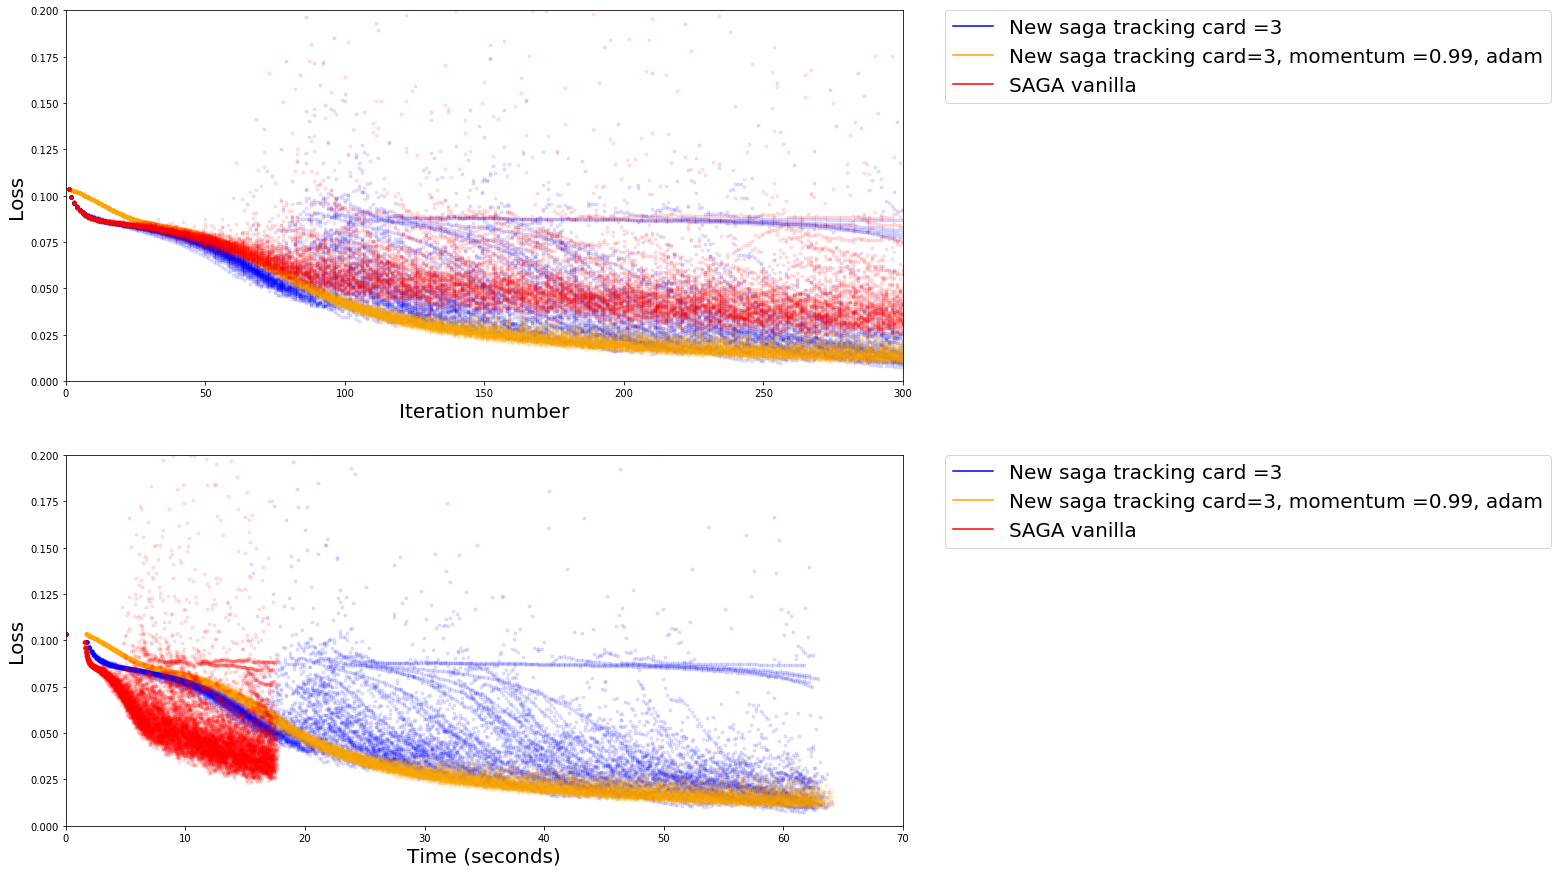

In [0]:
plt.figure(2,(15,15))
plt.subplot(211)
plt.axis([0,300,0,0.2])
for i in range(nb_courbes):
  col=couleurs[i]
  courbes=it[i]
  for courbe in courbes :
    plt.scatter(courbe[0],courbe[1],color=col, marker='.',alpha=0.1)
    
for i in range(nb_courbes):
    plt.plot([],[],color=couleurs[i],label=it[i][0][2])
plt.xlabel('Iteration number',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
    
    
plt.subplot(212)
plt.axis([0,70,0,0.2])
for i in range(nb_courbes):
    col=couleurs[i]
    courbes=tps[i]
    for courbe in courbes :
      plt.scatter(courbe[0],courbe[1],color=col, marker='.',alpha=0.1)

for i in range(nb_courbes):
    col=couleurs[i]
    plt.plot([],[],color=couleurs[i],label=tps[i][0][2])
plt.xlabel('Time (seconds)',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.show()

## Plusieurs batch

## Accuracys et Losses

In [0]:
T=80
nb=200
ACC=[]
Loss=[]

### Version quasi finale ?

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


batch 0 acc 0.15555555555555556
batch 1 acc 0.3323232323232323
batch 2 acc 0.34949494949494947
batch 3 acc 0.5202020202020202
batch 4 acc 0.6676767676767676
batch 5 acc 0.6505050505050505
batch 6 acc 0.6797979797979798
batch 7 acc 0.7252525252525253
batch 8 acc 0.7
batch 9 acc 0.705050505050505
batch 10 acc 0.7454545454545455
batch 11 acc 0.7070707070707071
batch 12 acc 0.7616161616161616
batch 13 acc 0.7505050505050505
batch 14 acc 0.7272727272727273
batch 15 acc 0.7707070707070707
batch 16 acc 0.7727272727272727
batch 17 acc 0.7858585858585858
batch 18 acc 0.7797979797979798
batch 19 acc 0.797979797979798
batch 20 acc 0.796969696969697
batch 21 acc 0.8464646464646465
batch 22 acc 0.8464646464646465
batch 23 acc 0.8333333333333334
batch 24 acc 0.8181818181818182
batch 25 acc 0.8131313131313131
batch 26 acc 0.8393939393939394
batch 27 acc 0.8363636363636363
batch 28 acc 0.8373737373737373
batch 29 acc 0.8343434343434344
batch 30 acc 0.8262626262626263
batch 31 acc 0.8494949494949495
ba

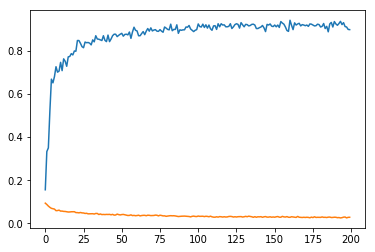

[0.15555555555555556, 0.3323232323232323, 0.34949494949494947, 0.5202020202020202, 0.6676767676767676, 0.6505050505050505, 0.6797979797979798, 0.7252525252525253, 0.7, 0.705050505050505, 0.7454545454545455, 0.7070707070707071, 0.7616161616161616, 0.7505050505050505, 0.7272727272727273, 0.7707070707070707, 0.7727272727272727, 0.7858585858585858, 0.7797979797979798, 0.797979797979798, 0.796969696969697, 0.8464646464646465, 0.8464646464646465, 0.8333333333333334, 0.8181818181818182, 0.8131313131313131, 0.8393939393939394, 0.8363636363636363, 0.8373737373737373, 0.8343434343434344, 0.8262626262626263, 0.8494949494949495, 0.8404040404040404, 0.8686868686868687, 0.8535353535353535, 0.8525252525252526, 0.8494949494949495, 0.8464646464646465, 0.8686868686868687, 0.8474747474747475, 0.8414141414141414, 0.8717171717171717, 0.8414141414141414, 0.8535353535353535, 0.8686868686868687, 0.8757575757575757, 0.8757575757575757, 0.8646464646464647, 0.8707070707070707, 0.8757575757575757, 0.8797979797979

In [0]:
model=copy_c(model_c)
criterion=nn.MSELoss()

acc=[]
loss=[]

optMiSAGAmi=new_SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0.99,adam=True,nag=True,ada=False)
optMiSAGAmi.Tracking=True
optMiSAGAmi.card_I=3
optMiSAGAmi.beta1=0
res=applique_opt_acc(optMiSAGAmi,nb,model,0.5)
acc=res[0]
loss=res[1]
plt.plot(range(len(acc)), acc,label='Accuracy')
plt.plot(range(len(loss)),loss,label='Loss')
plt.show()
print(acc)
print(loss)
ACC.append((acc,'Finale ?'))
Loss.append((loss,'Finale ?'))

### sasn momentum

In [0]:
model=copy_c(model_c)
criterion=nn.MSELoss()

acc=[]
loss=[]

optMiSAGAmi=new_SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0.)
optMiSAGAmi.proba=0
optMiSAGAmi.Tracking=True
optMiSAGAmi.card_I=3
optMiSAGAmi.beta1=0
res=applique_opt_acc(optMiSAGAmi,nb,model,0.5)
acc=res[0]
loss=res[1]
plt.plot(range(len(acc)), acc,label='Accuracy')
plt.plot(range(len(loss)),loss,label='Loss')
plt.show()
print(acc)
print(loss)
ACC.append((acc,'sans momentum'))
Loss.append((loss,'sans momentum'))

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


batch 0 acc 0.1414141414141414
batch 1 acc 0.2494949494949495
batch 2 acc 0.2777777777777778
batch 3 acc 0.4444444444444444
batch 4 acc 0.49696969696969695
batch 5 acc 0.6070707070707071
batch 6 acc 0.22121212121212122
batch 7 acc 0.47373737373737373
batch 8 acc 0.5909090909090909
batch 9 acc 0.6686868686868687
batch 10 acc 0.5838383838383838
batch 11 acc 0.6676767676767676
batch 12 acc 0.7191919191919192
batch 13 acc 0.7383838383838384
batch 14 acc 0.7464646464646465
batch 15 acc 0.7767676767676768
batch 16 acc 0.7747474747474747
batch 17 acc 0.7727272727272727
batch 18 acc 0.7585858585858586
batch 19 acc 0.8090909090909091
batch 20 acc 0.7727272727272727
batch 21 acc 0.7696969696969697
batch 22 acc 0.7808080808080808
batch 23 acc 0.593939393939394
batch 24 acc 0.7080808080808081
batch 25 acc 0.7555555555555555
batch 26 acc 0.7909090909090909
batch 27 acc 0.802020202020202
batch 28 acc 0.8101010101010101
batch 29 acc 0.7878787878787878
batch 30 acc 0.8171717171717172
batch 31 acc 0.83

### SAGA pure

In [0]:
model=copy_c(model_c)
criterion=nn.MSELoss()

acc=[]
loss=[]

optMiSAGAmi = SAGAmi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0)
res=applique_opt_acc(optMiSAGAmi,nb,model,0.5)
acc=res[0]
loss=res[1]
plt.plot(range(len(acc)), acc,label='Accuracy')
plt.plot(range(len(loss)),loss,label='Loss')
plt.show()
print(acc)
print(loss)
ACC.append((acc,'SAGA'))
Loss.append((loss,'SAGA'))

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


batch 0 acc 0.20303030303030303
batch 1 acc 0.2676767676767677
batch 2 acc 0.4666666666666667
batch 3 acc 0.5868686868686869
batch 4 acc 0.6353535353535353
batch 5 acc 0.6151515151515151
batch 6 acc 0.6585858585858586
batch 7 acc 0.6505050505050505
batch 8 acc 0.7222222222222222
batch 9 acc 0.705050505050505
batch 10 acc 0.7292929292929293
batch 11 acc 0.7606060606060606
batch 12 acc 0.7636363636363637
batch 13 acc 0.7838383838383839
batch 14 acc 0.8080808080808081
batch 15 acc 0.7747474747474747
batch 16 acc 0.7818181818181819
batch 17 acc 0.7909090909090909
batch 18 acc 0.7737373737373737
batch 19 acc 0.802020202020202
batch 20 acc 0.8171717171717172
batch 21 acc 0.8121212121212121
batch 22 acc 0.8262626262626263
batch 23 acc 0.8161616161616162
batch 24 acc 0.8373737373737373
batch 25 acc 0.8353535353535354
batch 26 acc 0.8181818181818182
batch 27 acc 0.8464646464646465
batch 28 acc 0.8414141414141414
batch 29 acc 0.8323232323232324
batch 30 acc 0.8414141414141414
batch 31 acc 0.8383

### SGD

In [0]:
model=copy_c(model_c)
criterion=nn.MSELoss()

acc=[]
loss=[]

optMiSAGAmi=SGDMi(trainloader,n,lr=0.5,f_momen=momen,model=model,T=T,momentum=0.)
res=applique_opt_acc(optMiSAGAmi,nb,model,0.5)
acc=res[0]
loss=res[1]
plt.plot(range(len(acc)), acc,label='Accuracy')
plt.plot(range(len(loss)),loss,label='Loss')
plt.show()
#print(acc)

ACC.append((acc,'SGD'))
Loss.append((loss,'SGD'))

### Affichages

In [0]:
# Affichage
plt.figure(2,(15,15))
plt.subplot(211)
for acc in ACC:
  plt.plot(range(len(acc[0])),acc[0],label=acc[1])
plt.xlabel('Nombre de batchs',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

plt.subplot(212)
for loss in Loss :
  plt.plot(range(len(loss[0])),loss[0],label=loss[1])
plt.xlabel('Nombre de batchs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)

plt.show()